In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
warnings.simplefilter(action='ignore', category=UndefinedMetricWarning)

# Predicting Credit Default.
#### Identifying risky credit patterns

We'll be analysing credit card data, collected in Taiwan (link below). Trying to predict patterns that lead to defaulting on credit. Various Machine Learning methods will be applied to the dataset. We will also try to derive some features to help our predictions. The 'real world' applications of these methods will be considered throughout our report. Balancing performance with predictive power will be a consideration throughout the report. 

https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

### Definitions:
**Default:** After you’ve failed to make a payment on your credit card for 180 days, your issuer assumes you’re probably never going to. At this point, the issuer can (and usually does) close your card, write off what you owe as bad debt and sell your account to a collections agency.

In [8]:
df = pd.read_csv("default_cc_train.csv", sep=',')
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,8811,390000,2,1,1,64,1,-2,-2,-2,...,0,0,8668,0,0,0,0,8668,4490,1
1,23496,60000,2,2,2,31,0,0,0,2,...,42057,26877,26493,4100,4073,0,1600,0,1100,1
2,1164,210000,2,2,1,39,0,0,0,0,...,19850,15530,13021,14000,3007,5000,1000,13021,22171,0
3,19421,500000,2,1,1,35,-2,-1,0,-1,...,7896,8970,215305,36277,6112,10014,9018,215518,20018,0
4,16890,150000,1,1,2,37,2,2,2,2,...,38687,37765,40352,1600,0,3300,0,3200,1700,1


Text(0.5,1,'Correlation of features')

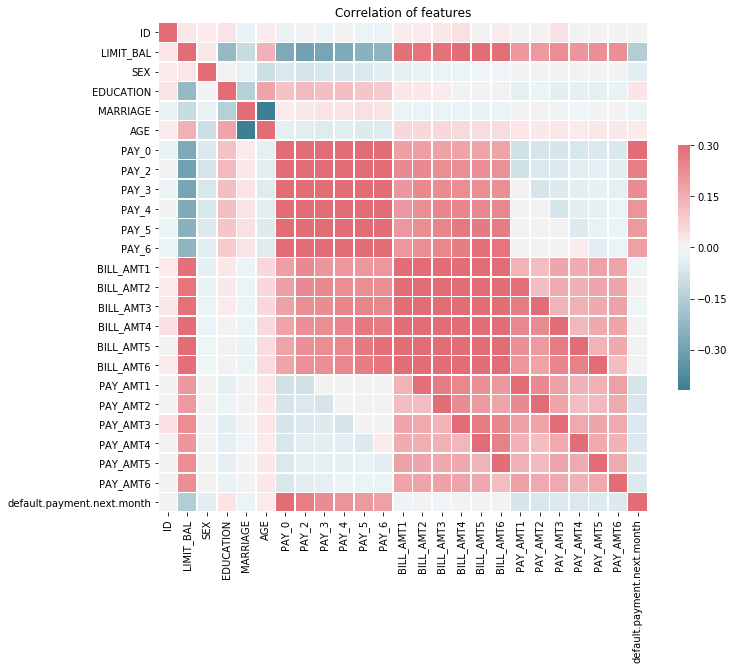

In [9]:
corr = df.corr()
mask = np.zeros_like(corr,dtype=np.bool)
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True,
            linewidths=.5, cbar_kws={"shrink": .5})
plt.title('Correlation of features')

In [10]:
df.info()
print("Shape: ",df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 25 columns):
ID                            25000 non-null int64
LIMIT_BAL                     25000 non-null int64
SEX                           25000 non-null int64
EDUCATION                     25000 non-null int64
MARRIAGE                      25000 non-null int64
AGE                           25000 non-null int64
PAY_0                         25000 non-null int64
PAY_2                         25000 non-null int64
PAY_3                         25000 non-null int64
PAY_4                         25000 non-null int64
PAY_5                         25000 non-null int64
PAY_6                         25000 non-null int64
BILL_AMT1                     25000 non-null int64
BILL_AMT2                     25000 non-null int64
BILL_AMT3                     25000 non-null int64
BILL_AMT4                     25000 non-null int64
BILL_AMT5                     25000 non-null int64
BILL_AMT6               

Looks like its a full 25000 rows with no null values. Does not look like any data cleaning will be needed only scaling and preprocessing.

Text(0.5,0,'Default payments')

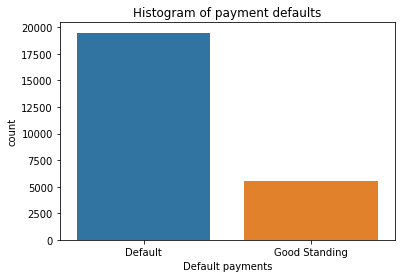

In [11]:
sns.countplot(df['default.payment.next.month'])
plt.title('Histogram of payment defaults')
plt.xticks((0,1),('Default','Good Standing'))
plt.xlabel('Default payments')

In [12]:
print( 'Percentage of default: '+ str(100*len(df[df['default.payment.next.month'] ==1]) / len(df) ))

Percentage of default: 22.056


About one in every 3.5-4 people will end up defaulting. 

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


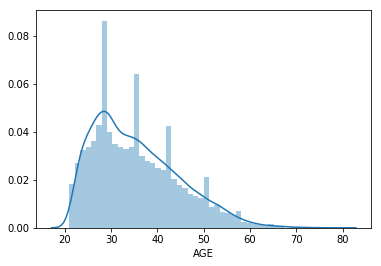

In [13]:
sns.distplot(df['AGE'])

Interesting distribution here, large concentrations around 28, 35, 43, and 52

([<matplotlib.axis.XTick at 0x1a21e147b8>,
 <a list of 7 Text xticklabel objects>)

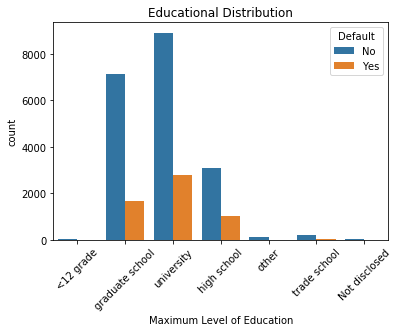

In [14]:
sns.countplot('EDUCATION',hue='default.payment.next.month',data=df)
plt.title('Educational Distribution')
plt.xlabel('Maximum Level of Education')
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.xticks((0,1,2,3,4,5,6),('<12 grade','graduate school','university','high school','other','trade school','Not disclosed'),rotation=45)

Our debtors are mostly educated people. There appears to be no significance in the relationship between education and defaulting on your credit card. 

Text(0.5,1,'Relationship Status')

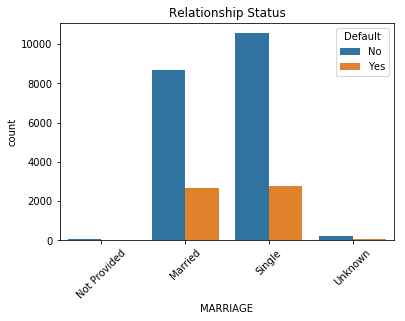

In [15]:
#mar_map = {0:'Not Provided',1:'Married',2:'Single',3:'Unknown'}
#mar_status = [mar_map[stat] for stat in df['MARRIAGE']]
sns.countplot('MARRIAGE', hue='default.payment.next.month',data=df)
plt.xticks((0,1,2,3),('Not Provided','Married','Single','Unknown'),rotation=45)
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')
plt.title('Relationship Status')

A greater percentage of married people end up defaulting on their debt. One would suspect otherwise, with the additional responsibility and future planning that usually comes with marriage. But perhaps single people have fewer financial burdens, like children, and are less likely to overextend themselves financially. 

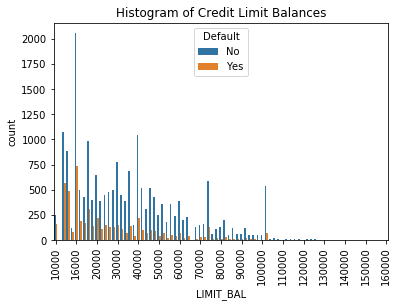

In [16]:
plot = sns.countplot(df['LIMIT_BAL'],hue = df['default.payment.next.month'])
plot.set_xticks(plot.get_xticks()[::5])
plot = plt.xticks(rotation=90)
plt.title('Histogram of Credit Limit Balances')
L = plt.legend(title='Default')
L.get_texts()[0].set_text('No')
L.get_texts()[1].set_text('Yes')

Kind of a hard figure to see but shows the reationship between a persons balance limit and thier defualt. Generally a higher percentage of people with lower limit balances will end up defaulting. If you're a 'high risk' applicant the bank usually will only approve you for a smaller line of credit. This graph might help show why that is. 

Text(0.5,1,'Limit Balance and default distribution')

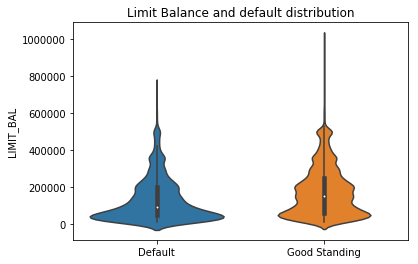

In [17]:
default_labs = {0:'Good Standing',1:'Default'}
default = [default_labs[x] for x in df['default.payment.next.month']]
sns.violinplot(x=default, y='LIMIT_BAL',data=df)
plt.title("Limit Balance and default distribution")

Perhaps not very surprisingly, people with higher limit balances are less likely to to be defaulting. The defaulters had a lower average credit limit. Likely they already had a lower credit score to begin with. 

Text(0.5,0,'')

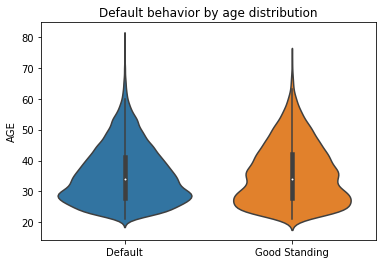

In [18]:
sns.violinplot('default.payment.next.month', y='AGE',data=df)
plt.title('Default behavior by age distribution')
plt.xticks((0,1),('Default','Good Standing'))
plt.xlabel('')

Almost no difference at all in age distributions between defaulters and not. A little surprising actually. One would imagine younger people defaulting more. 

#### Bill amounts
According to the correlation plot above, the most significant features for predicting default payments will be the BILL_AMT fields. Let's visualize a couple to see what we can infer from them

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


Text(0.5,0,'Money Owed')

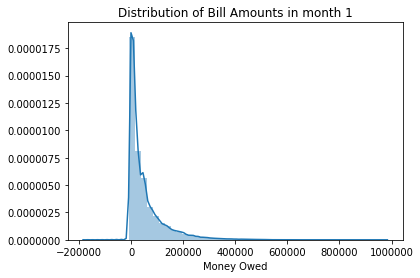

In [19]:
sns.distplot(df['BILL_AMT1'])
plt.title('Distribution of Bill Amounts in month 1')
plt.xlabel('Money Owed')

A very steep distirbution toward the lowerd end of money owed. Is this the general pattern this data will follow? Lets look at another month to be sure.

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


(-50000, 600000)

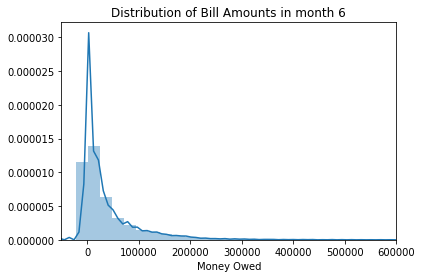

In [20]:
sns.distplot(df['BILL_AMT6'])
plt.title('Distribution of Bill Amounts in month 6')
plt.xlabel('Money Owed')
plt.xlim((-50000,600000))

Almost exactly the same. This seems to make sense. Most people won't want ot have too much debt. The vast majority of people have debt below about 50,000 (not sure if this is measured in Dollars or Yen. 

Text(0.5,0,'Payment Status')

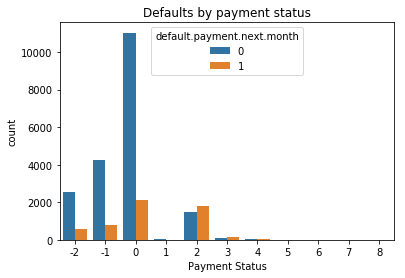

In [21]:
sns.countplot(x='PAY_2', hue = 'default.payment.next.month' , data = df)
plt.title('Defaults by payment status')
plt.xlabel('Payment Status')

Not everyone that pays on time, or is paid up in a given month is guaranteed not to default. But for the folks that are already a few months late, it looks like you're more likely to end up in default than you are to end up paying off your debt. As we saw earlier in the correlation plot, payment status will be a very strong predictor of default.

### Derived Features: 
#### To add or not to add?
Our team played with a few strategies to sythesize some more features. Some features tested were: ratio of money owed to total balance, sum off amounts owed across each month, as well as a couple others trying to get something more meaningful out of the 'limit balance', 'pay amount' and 'bill amount'. Below is some featur engineering we've done, and through this we've managed to bump our average predictions up a couple %. No revolutionary gains, but something is better than nothing. 

In [22]:
"""
Transformer class for the
    [default of credit card clients]
    (https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)
Data Set.

Usage:
    import preprocessing
    transformer = preprocessing.Transformer()
    X_train = transformer.fit_transform(df_train)
    X_test = transformer.transform(df_test)
"""
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder


def _get_cols(prefix, from_idx, to_idx):
    res = []
    for i in range(from_idx, to_idx + 1):
        res.append(prefix + str(i))
    return res


class FeatureEngineer(TransformerMixin):
    """
    A Transformer for Feature Enginnering
    """
    PAY_AMTS = _get_cols('PAY_AMT', 1, 6)
    BILL_AMTS = _get_cols('BILL_AMT', 1, 6)
    PAYS = ['PAY_0'] + _get_cols('PAY_', 2, 6)

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        dataframe['TOT_PAY_AMT'] = self._tot_pay_amt(dataframe)
        dataframe['TOT_BILL_AMT'] = self._tot_bill_amt(dataframe)
        dataframe['TOT_MOD'] = self._tot_month_of_delays(dataframe)
        dataframe['NUM_NO_COMSP'] = self._num_of_no_consumption(dataframe)
        dataframe['NUM_NO_DLY'] = self._num_of_no_delay(dataframe)
        return dataframe

    def _tot_pay_amt(self, dataframe):
        return dataframe[self.PAY_AMTS].sum(axis=1)

    def _tot_bill_amt(self, dataframe):
        return dataframe[self.BILL_AMTS].sum(axis=1)

    def _tot_month_of_delays(self, dataframe):
        return dataframe[self.PAYS].replace([-2, -1], 0).sum(axis=1)

    def _num_of_no_consumption(self, dataframe):
        return (dataframe[self.PAYS] == -2).sum(axis=1)

    def _num_of_no_delay(self, dataframe):
        return (dataframe[self.PAYS] == -1).sum(axis=1)


class NumFeatureSelector(TransformerMixin):
    """
    Select Numeric Features
    """
    FEATURES_ = [
        'LIMIT_BAL', 'AGE', 'TOT_PAY_AMT', 'TOT_BILL_AMT', 'TOT_MOD',
        'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5',
        'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4',
        'PAY_AMT5', 'PAY_AMT6'
    ]

    def __init__(self, features):
        super().__init__()
        self.features = features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        return dataframe[self.features].values


class CatFeatureSelector(TransformerMixin):
    """
    Select Categorical Features
    """
    FEATURES_ = [
        'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
        'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6',
        'NUM_NO_COMSP', 'NUM_NO_DLY'
    ]

    def __init__(self, features=None):
        super().__init__()
        self._encoder = None
        if features is None:
            features = self.CAT_FEATURES_
        self.features = features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self._encoder = OneHotEncoder(handle_unknown='ignore')
        X = dataframe[self.features].astype('int32')
        X -= X.min().min()
        self._encoder.fit(X)
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        X = dataframe[self.features].astype('int32')
        X -= X.min().min()
        return self._encoder.transform(X).toarray()

    def feature_indices(self):
        return self._encoder.feature_indices_


class Transformer(TransformerMixin):
    """
    Transform the `default of credit card clients` data
    """
    _feature_enginner = FeatureEngineer()

    def __init__(self, num_features=None, cat_features=None):
        super().__init__()
        self._need_to_fit = True
        self._pipe = None
        self.df = None
        self.cat_selector = None
        if num_features is None:
            num_features = NumFeatureSelector.FEATURES_
        if cat_features is None:
            cat_features = CatFeatureSelector.FEATURES_
        self.num_features = num_features
        self.cat_features = cat_features

    def fit(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self._need_to_fit = True
        return self

    def transform(self, dataframe):
        """
        :type dataframe pandas.DataFrame
        """
        self.df = self._feature_enginner.fit_transform(dataframe)
        if self._need_to_fit:
            self._need_to_fit = False
            self.cat_selector = CatFeatureSelector(self.cat_features)
            self._pipe = Pipeline([
                ('Feature Union', FeatureUnion([
                    ('Numeric Features', NumFeatureSelector(self.num_features)),
                    ('Encoded Categorical Features', self.cat_selector),
                ])),
                ('Standard Scaler', StandardScaler()),
            ])
            return self._pipe.fit_transform(self.df)
        return self._pipe.transform(self.df)

    def feature_importances(self, importances):
        """
        :type importances numpy.ndarray
        """
        indices = self.cat_selector.feature_indices()
        col = len(self.num_features)
        cat_scores = np.zeros(len(self.cat_features))
        for i in range(1, len(indices)):
            cat_scores[i - 1] = np.sum(importances[
                (col + indices[i - 1]):(col + indices[i])
            ])
        return pd.DataFrame({
            'feature': self.num_features + self.cat_features,
            'importance': np.concatenate((
                importances[:len(self.num_features)],
                cat_scores
            ))
        }).sort_values(by=['importance'], ascending=False)

The `Transformer` class wraps the entire preprocessing logic. It contains feature engineering, selecting numeric and categorical features and transform them into indicator variables. It also provides a utility method to restore the original feature importance for the categorical features.

The new features are 

`TOT_PAY_AMT`: Total payment in the 6 months.

`TOT_BILL_AMT`: Total payment in the 6 months.

`TOT_MOD`: Number of the month of delay. 

`NUM_NO_COMSP`: Number of months without consumption (with pay value of `-2`)

`NUM_NO_DLY`: Number of months paid on time in full (with pay value of `-1`)

In [23]:
transformer = Transformer()
X = transformer.fit_transform(df)
df = transformer.df

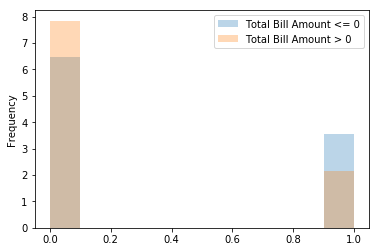

In [24]:
def get_color(x):
    return 'b' if x == 0 else 'r'

df[df['TOT_BILL_AMT'] <= 0]['default.payment.next.month'].plot(kind='hist', density=1, alpha=.3)
df[df['TOT_BILL_AMT'] > 0]['default.payment.next.month'].plot(kind='hist', density=1, alpha=.3)
plt.legend(['Total Bill Amount <= 0', 'Total Bill Amount > 0'])

We found people with negative total bill amount are more likely to default.

(array([-250000.,       0.,  250000.,  500000.,  750000., 1000000.,
        1250000., 1500000., 1750000., 2000000.]),
 <a list of 10 Text xticklabel objects>)

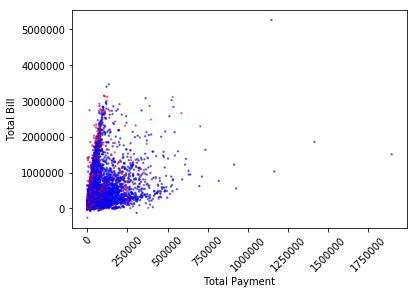

In [25]:
plt.scatter(df['TOT_PAY_AMT'], df['TOT_BILL_AMT'], s=2, alpha=0.5, c=list(map(get_color, df['default.payment.next.month'])))
plt.xlabel('Total Payment')
plt.ylabel('Total Bill')
plt.xticks(rotation=45)

Text(0,0.5,'Total Bill')

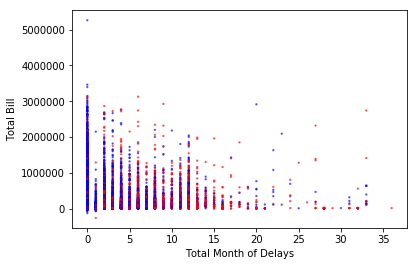

In [26]:
plt.scatter(df['TOT_MOD'], df['TOT_BILL_AMT'], s=2, alpha=0.5, c=list(map(get_color, df['default.payment.next.month'])))
plt.xlabel('Total Month of Delays')
plt.ylabel('Total Bill')

The total month of delays is the sum of the `PAY` columns excluding the negative values. This new feature indicates people with high total month of delays are more likely to default.

# Trying classifiers
We will test out a broad suite of Machine Learning algorithms, as well as a few ensemble methods to find the best means of predicting defaulters.

In [27]:
from sklearn.naive_bayes import GaussianNB 
from sklearn.model_selection import train_test_split

from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
import pandas as pd
import os
from sklearn.neighbors import KNeighborsClassifier as knn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import  VotingClassifier,GradientBoostingClassifier, AdaBoostClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDRegressor,LinearRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import r2_score
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [28]:
pd.set_option('mode.chained_assignment', None)
X = transformer.fit_transform(df)
y = df['default.payment.next.month']

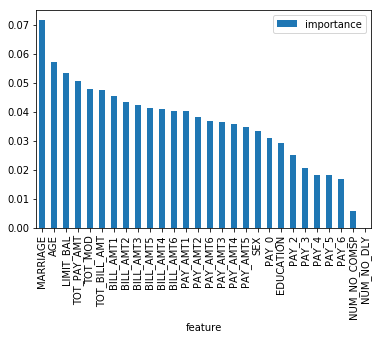

In [29]:
rand_frst = RandomForestClassifier(n_estimators=100).fit(X, y)
transformer.feature_importances(rand_frst.feature_importances_).plot(kind='bar', x='feature')

In [30]:
transformer = Transformer(cat_features=[
    'SEX', 'MARRIAGE', 'PAY_0'
])
X = transformer.fit_transform(df)
y = df['default.payment.next.month']

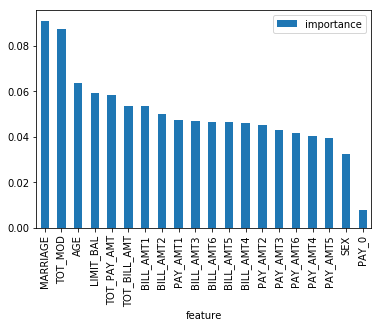

In [31]:
rand_frst = RandomForestClassifier(n_estimators=100).fit(X, y)
transformer.feature_importances(rand_frst.feature_importances_).plot(kind='bar', x='feature')

One of the derived feature `TOT_MOD` has high feature importance value according to a random forest classifier.
We remove the categorical variables with low feature importance value to reduce the dimensionality and improve the performance of the model.

### ML Specific Preprocessing

In [32]:
from sklearn.model_selection import \
        GridSearchCV, \
        learning_curve, \
        train_test_split
from sklearn.metrics import \
        accuracy_score, \
        confusion_matrix, \
        roc_curve, \
        precision_recall_fscore_support
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


class Model:
    def __init__(self, name, base_estimator, param_grid):
        """
        A model is constructed by `ModelSelection.search_and_test`
        """
        self.name = name
        self.base_estimator = base_estimator
        self.param_grid = param_grid
        self.id = None
        self.best_estimator = None
        self.best_params = None
        self.train_score = None
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.fbeta = None
        self.support = None
        self.tn = None
        self.tp = None
        self.fn = None
        self.fp = None
        

    def as_df(self):
        return pd.DataFrame({
            'id': [self.id],
            'name': [self.name],
            'best_params': [self.best_params],
            'train_score': [self.train_score],
            'accuracy': [self.accuracy],
            'precision': [self.precision],
            'recall': [self.recall],
            'fbeta': [self.fbeta],
            'support': [self.support],
            'tn': [self.tn],
            'tp': [self.tp],
            'fn': [self.fn],
            'fp': [self.fp]
        }).set_index('id')


class ModelSelection:
    TARGET_ = 'default.payment.next.month'

    def __init__(self, df, transformer, test_size, max_parallelism=None):
        df_train, df_test = train_test_split(df, test_size=test_size)
        self.X_train = transformer.fit_transform(df_train)
        self.y_train = df_train[self.TARGET_]
        self.X_test = transformer.transform(df_test)
        self.y_test = df_test[self.TARGET_]
        self.models = []
        self.max_parallelism = max_parallelism

    def search_and_test(self, name, base_estimator, param_grid, cv=5, verbose=1):
        """
        Perform Grid Search on the param grid & Test the best model

        Parameters
        ----------
        name: string

        base_estimator: sklearn.estimator

        param_grid: dict
            param_grid for GridSearch

        cv: int, cross-validation generator or an iterable, optional
        """
        model = Model(name, base_estimator, param_grid)
        gs = GridSearchCV(base_estimator, param_grid=param_grid,
                          cv=cv, n_jobs=self.max_parallelism, verbose=verbose)
        if verbose != 0:
            print('Starting Grid Search')
        gs.fit(self.X_train, self.y_train)
        model.best_params = gs.best_params_
        model.best_estimator = gs.best_estimator_
        model.train_score = gs.best_score_
        if verbose != 0:
            print('Fitting the best estimator')
        model.best_estimator.fit(self.X_train, self.y_train)
        if verbose != 0:
            print('Testing the best estimator')
        y_pred = model.best_estimator.predict(self.X_test)
        model.accuracy = accuracy_score(self.y_test, y_pred)
        cm = confusion_matrix(self.y_test, y_pred)
        model.tn, model.fp, model.fn, model.tp = cm.ravel()
        scores = precision_recall_fscore_support(
            self.y_test, y_pred, average='binary'
        )
        model.precision, model.recall, model.fbeta, model.support = scores
        model.id = len(self.models)
        self.models.append(model)
        return model

    def plot_confusion_matrix(self, model, normalize=True):
        """
        Plots the confusion matrix for the model

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method
        """
        df_cm = pd.DataFrame({
            0: [model.tn, model.fn],
            1: [model.fp, model.tp]
        })
        if normalize:
            total = model.tn + model.tp + model.fn + model.fp
            df_cm = df_cm.astype('float') / total
        plt.figure()
        sns.heatmap(df_cm, annot=True)
        plt.title('Confusion Matrix\n{}\n{}'.format(
            model.name, model.best_params
        ))
        plt.ylabel("True")
        plt.xlabel("Prediction")
        plt.tight_layout()
        return plt

    def plot_learning_curve(self, model, ylim=None, cv=None,
                            train_sizes=np.linspace(.5, 1.0, 5)):
        """
        Generate a simple plot of the test and training learning curve.
        http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method

        ylim : tuple, shape (ymin, ymax), optional
            Defines minimum and maximum yvalues plotted.

        cv : int, cross-validation generator or an iterable, optional

        train_sizes : array-like, shape (n_ticks,), dtype float or int
            Relative or absolute numbers of training examples that will be used to
            generate the learning curve. If the dtype is float, it is regarded as a
            fraction of the maximum size of the training set (that is determined
            by the selected validation method), i.e. it has to be within (0, 1].
            Otherwise it is interpreted as absolute sizes of the training sets.
        """
        plt.figure()
        plt.title("{}\n{}".format(model.name, model.best_params))
        if ylim is not None:
            plt.ylim(*ylim)
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        train_sizes, train_scores, test_scores = learning_curve(
            model.best_estimator, self.X_train, self.y_train, cv=cv,
            n_jobs=self.max_parallelism, train_sizes=train_sizes)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)
        plt.grid()

        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")

        plt.legend(loc="best")
        return plt

    def get_predictions(self, model):
        '''
        Get the predictions from a model given multiple parameters to test
    
        Parameters
        ----------
        model: Used for training to get predictions
        '''
        flat = [[(k, v) for v in vs] for k, vs in model.param_grid.items()]
        parameters_flat = [dict(items) for items in product(*flat)]
   
        predictions = []
        for i in parameters_flat:
            model.base_estimator.set_params(**i)
            model.base_estimator.fit(self.X_train,self.y_train)
            predict = model.base_estimator.predict(self.X_test)
            predictions.append(predict)
        return predictions, parameters_flat
    
    def plot_PR(self, model, predictions, parameters_flat):
        '''
        Generates a Precision Recall plot for our model given a set of parameters to search through
        
        Parameters
        ----------
        model:Used for getting the name, and best aprameters for title
        
        predictions : An array of predictions from a model given multiple parameters to test
        
        parameters_flat: a set of all the possible parameters for testing.
        '''
        model_name = list(range(0,400))
        count = 0
        a = np.empty((1,4))

        plt.figure()
        for i in predictions:
            precision, recall, f, beta = precision_recall_fscore_support(self.y_test, i, average='binary')
            a = np.append(a, np.array([[model_name[count],parameters_flat[count],precision,recall]]),axis = 0)
            plt.scatter(precision, recall)
            count = count + 1
        plt.xlabel("precision")
        plt.ylabel("recall")
        plt.title('Confusion Matrix\n{}\n{}'.format(
            model.name, model.best_params
        ))

        legend = pd.DataFrame(a[1:])
        legend.columns = ['model#', 'parameters','precision','recall']
        plt.show()
        #return(legend)
    
    def plot_ROC(self, model, predictions, parameters_flat):
        """
        Generates a ROC scatter plot for our model given a set of parameters to search through

        Parameters
        ----------
        model:Used for getting the name, and best aprameters for title
        
        predictions : An array of predictions from a model given multiple parameters to test
        
        parameters_flat: a set of all the possible parameters for testing.
        """
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        model_name = list(range(0,600))
        a = np.empty((1,4))

        count = 0
        plt.figure()
        for i in predictions: 
            fpr, tpr, thresholds = roc_curve(self.y_test, i)      
            plt.scatter(fpr, tpr)
            a = np.append(a, np.array([[model_name[count],parameters_flat[count],fpr,tpr]]),axis = 0)
            count = count + 1
        
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Confusion Matrix\n{}\n{}'.format(
            model.name, model.best_params
        ))      
        plt.show()
    
        legend = pd.DataFrame(a[1:])
        legend.columns = ['model#', 'parameters','fpr','tpr']
        #return(legend)
    
    def plot_ROC_PR(self, model):
        '''
        Plot the Precision Recall and Receiver Operating curves
    
        Parameters
        ----------
        model: stores the values of parameters and predictions
            
        '''    
        predictions, parameters = self.get_predictions(model)
        legend1 = self.plot_ROC(model, predictions, parameters)
        legend2 = self.plot_PR(model, predictions, parameters)
        legends = [legend1,legend2]
        #return legends 

    def plot(self, model, verbose=1):
        """
        Generates all the plots we have for the model

        Parameters
        ----------
        model : Model
            A model should be contructed by `search_and_test` method
        """
        if verbose != 0:
            print('Plotting the Confusion Matrix')
        self.plot_confusion_matrix(model)
        if verbose != 0:
            print('Plotting the Learning Curve')
        self.plot_learning_curve(model)
        if verbose != 0:
            print('Plotting the Precision vs Recall')
        self.plot_ROC_PR(model)


    def as_df(self):
        """
        Output the models as a pandas dataframe
        """
        return pd.concat(
            [model.as_df() for model in self.models]
        ).sort_values(by=['accuracy'], ascending=False)

In [33]:
selector = ModelSelection(df, transformer, test_size=0.3, max_parallelism=8)

## Gradient Boosting Classifier

In [ ]:
gb = selector.search_and_test(
    'Gradient Boosting Classifier',
    GradientBoostingClassifier(),
    {
        'n_estimators': range(1, 20, 2),
        'max_depth': range(1, 10, 2),
        'learning_rate': [0.01, 0.1, 1]
    }
)
selector.plot(gb)
gb.as_df()

## Stochastic Gradient Desecent

In [ ]:
sgd = selector.search_and_test(
    'Stochastic Gradient Desecent Classifier',
    SGDClassifier(),
    {
        'alpha': [0.001, 0.01, 0.1, 1],
        'loss': ['hinge', 'modified_huber', 'log'],
        'penalty': ['l2', 'l1', 'elasticnet'],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(sgd)
sgd.as_df()

## Support Vector Machine

Starting Grid Search
Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  4.3min
[Parallel(n_jobs=8)]: Done 150 out of 150 | elapsed: 18.4min finished


Fitting the best estimator
Testing the best estimator
Plotting the Confusion Matrix
Plotting the Learning Curve
Plotting the Precision vs Recall


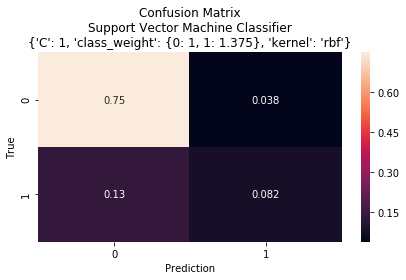

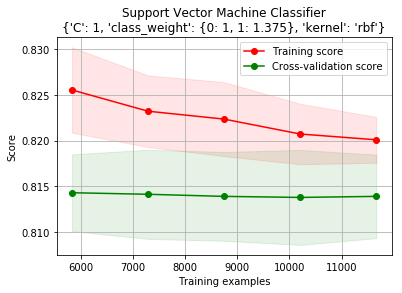

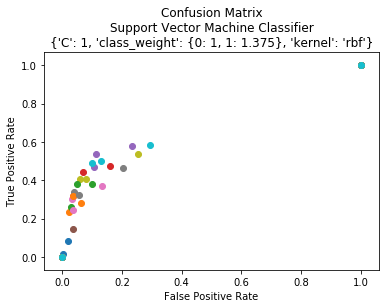

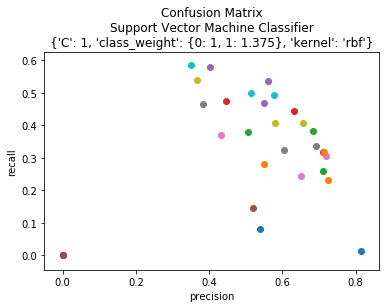

,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
0,Support Vector Machine Classifier,"{'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...",0.8144,0.8296,0.682628,0.381694,0.489617,None,5609,613,993,285


In [34]:
svc = selector.search_and_test(
    'Support Vector Machine Classifier',
    svm.SVC(),
    {
        'kernel': ['rbf', 'sigmoid'],
        'C': [0.01, 0.1, 1],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(svc)
svc.as_df()

## K-Nearest Neighbors

In [ ]:
knn = selector.search_and_test(
    'K-Nearest Neighbors Classifier',
    KNeighborsClassifier(),
    {
        'n_neighbors': range(1, 3, 2)
    }
)
selector.plot(knn)
knn.as_df()

## Decision Tree

In [ ]:
dt = selector.search_and_test(
    'Decision Tree Classifier',
    DecisionTreeClassifier(),
    {
        'max_depth': range(1, 5),
        'max_features': [None, 3, 6, 18],
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.0, 5)
        ]
    }
)
selector.plot(dt)
dt.as_df()

# Random Forest

In [ ]:
rf = selector.search_and_test(
    "Random Forest Classifier",
    RandomForestClassifier(),
    {
        'n_estimators': range(35, 46),
        'max_depth': range(3, 13, 2),
        'class_weight': [
            {0: 1, 1: i} for i in np.linspace(0.25, 2.5, 5)
        ]
    }
)
selector.plot(rf)
rf.as_df()

## ADA-Boost

In [ ]:
ada = selector.search_and_test(
    "ADA Boost Classifier",
    AdaBoostClassifier(dt.best_estimator),
    {
        'n_estimators': range(10, 100, 10),
        'learning_rate': [0.001, 0.01, 1]
    }
)
selector.plot(ada)
ada.as_df()

# Selected Model

In [35]:
selector.as_df()

,name,best_params,train_score,accuracy,precision,recall,fbeta,support,tn,tp,fn,fp
id,,,,,,,,,,,,
0,Support Vector Machine Classifier,"{'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...",0.8144,0.8296,0.682628,0.381694,0.489617,None,5609,613,993,285


## Best Predictor:

In [42]:
models = selector.as_df()

models.iloc[0]
#selector.models[0].name

name                           Support Vector Machine Classifier
best_params    {'C': 1, 'class_weight': {0: 1, 1: 1.375}, 'ke...
train_score                                               0.8144
accuracy                                                  0.8296
precision                                               0.682628
recall                                                  0.381694
fbeta                                                   0.489617
support                                                     None
tn                                                          5609
tp                                                           613
fn                                                           993
fp                                                           285
Name: 0, dtype: object

# Please Enter New Test Data Here

In [ ]:
#please enter file string for test data to be used in grading report
test_data_file_string = ''  # enter file string of new test data

def bundle_predict(estimator,train_dat,test_dat):
    '''
    takes in new training and test data, transforms, then trains
    and predicts on new training and test sets.

    Parameters
    ---------------
    estimator

    train_dat - pandas dataframe (the 25K rows of data collected from:
    https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients)

    train_dat - pandas dataframe ( the new data provided by the grader of the project, Dr. Bruns)
    '''
    TARGET_ = 'default.payment.next.month'
    y_train_dat = train_dat[TARGET]
    train_dat = train_dat.drop([TARGET])
    y_test_dat = test_dat[TARGET]
    test_dat = test_dat [TARGET]
    transformer = Transformer()
    #fit and transform data
    train_dat = transformer.fit_transform(train_dat)
    #transform test data with fit from training data
    test_dat = transformer.transform(test_dat)
    estimator.fit(train_dat,y_train_dat)
    estimaror.predict(test_dat,y_test_dat)


#read in ALL data previously used to be used ONLY as training data
train_dat = pd.read_csv("default_cc_train.csv", sep=',')

#read in new test data
test_dat = pd.read_csv(test_data_file_string) 

bundle_predict(estimator,train_dat,test_dat)



    

# Conclusion
Our best prediction accuracy was around 82-83%, our lowest measured prediction accuracy was about 80%. This is not a particularly large spread, especially considering the disparity in the time it takes for some models to train with the Grid Search to find the best hyper-parameters.
Two things we'd like to persue in the next week that can help refine the power of our predictions would be: 
1. A comparison of the time required to train models vs. their predictive power.
2. Possibly pursuing some solutions that increase the cost function to mitigate the high occurance of false negatives that we've seen in most of our predictions. It is in the lending body's interest to extend credit to the absolute fewest amount of people that might default on that credit. As it stands, we would be granting too much credit to people that end up not paying back their loans. 